# Slice take home exercise

In [29]:
# read from csv file
import numpy as np
import pandas as pd
import io
import requests

In [30]:
df = pd.read_csv('churn_homework - homework_orders.csv')

source: remove three items and keep iosapp, partner_website, slicelife, androidapp, partner_button. The other three has really small sample size. 
date_purchased: Convert to datetime
promo_value: 0 is no promo other 5 specifies how much saving in an order in dollar val. 
restaurant_total: there are some minus values, which needs to be cleaned up. Typical earning is ~$28

## Explore dataset

In [2]:
# explore data
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title = 'Churn homework dataset', explorative=True)
profile

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# convert formats
df['date_purchased_as_date'] = pd.to_datetime(df.date_purchased)
df['customer'] = df.customer.astype(str)
df.head()

order_id           source            date_purchased shipping_type  \
0  47433960           iosapp  2019-03-13T08:02:07.000Z      Delivery   
1  47434359           iosapp  2019-03-13T08:11:38.000Z      Delivery   
2  47437194  partner_website  2019-03-13T09:07:31.000Z      Delivery   
3  47442942  partner_website  2019-03-13T11:01:04.000Z      Delivery   
4  47443107  partner_website  2019-03-13T11:04:56.000Z      Delivery   

  payment_method  promo_value  restaurant_total       customer  shops_id  \
0         credit            0             15.50  13315067198.0     24597   
1         credit            0             24.83  15557129447.0     64392   
2           cash            0             43.24  25689365012.0     33699   
3         credit            0             27.95  25421112251.0     19002   
4         credit            0             23.15  18529185191.0     34911   

  state  postal_code    date_purchased_as_date  
0    MD        21162 2019-03-13 08:02:07+00:00  
1    NY        12944 2019-03-13 08:11:38+00:00  
2    NJ         8007 2019-03-13 09:07:31+00:00  
3    WI        53235 2019-03-13 11:01:04+00:00  
4    MA         2122 2019-03-13 11:04:56+00:00

## Create a Purchase Period variable

In [32]:
import datetime
# create period column based on first order date
df['PurchasePeriod'] = pd.to_datetime(df.date_purchased).apply(lambda x: x.strftime('%Y-%m'))
df.head()

order_id           source            date_purchased shipping_type  \
0  47433960           iosapp  2019-03-13T08:02:07.000Z      Delivery   
1  47434359           iosapp  2019-03-13T08:11:38.000Z      Delivery   
2  47437194  partner_website  2019-03-13T09:07:31.000Z      Delivery   
3  47442942  partner_website  2019-03-13T11:01:04.000Z      Delivery   
4  47443107  partner_website  2019-03-13T11:04:56.000Z      Delivery   

  payment_method  promo_value  restaurant_total       customer  shops_id  \
0         credit            0             15.50  13315067198.0     24597   
1         credit            0             24.83  15557129447.0     64392   
2           cash            0             43.24  25689365012.0     33699   
3         credit            0             27.95  25421112251.0     19002   
4         credit            0             23.15  18529185191.0     34911   

  state  postal_code    date_purchased_as_date PurchasePeriod  
0    MD        21162 2019-03-13 08:02:07+00:00        2019-03  
1    NY        12944 2019-03-13 08:11:38+00:00        2019-03  
2    NJ         8007 2019-03-13 09:07:31+00:00        2019-03  
3    WI        53235 2019-03-13 11:01:04+00:00        2019-03  
4    MA         2122 2019-03-13 11:04:56+00:00        2019-03

In [33]:
df.PurchasePeriod.value_counts()

2020-03    4767
2020-02    4585
2020-04    4230
2020-01    3828
2019-12    3589
2019-11    3176
2019-10    2917
2019-08    2578
2019-09    2444
2019-07    2268
2019-05    1913
2019-06    1862
2020-05    1572
2019-04    1504
2019-03     956
Name: PurchasePeriod, dtype: int64

## Determine Cohort Group (based on the first order)

In [34]:
# set up Cohort Group variable based on year and month

df.set_index('customer', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['date_purchased_as_date'].min().apply(lambda x: x.strftime('%Y-%m'))
df['first_order_date'] = df.groupby(level=0)['date_purchased_as_date'].min().apply(lambda x: x.replace(day=1))#strftime('%Y-%m'))

df.reset_index(inplace=True)
df.head()

customer  order_id           source            date_purchased  \
0  13315067198.0  47433960           iosapp  2019-03-13T08:02:07.000Z   
1  15557129447.0  47434359           iosapp  2019-03-13T08:11:38.000Z   
2  25689365012.0  47437194  partner_website  2019-03-13T09:07:31.000Z   
3  25421112251.0  47442942  partner_website  2019-03-13T11:01:04.000Z   
4  18529185191.0  47443107  partner_website  2019-03-13T11:04:56.000Z   

  shipping_type payment_method  promo_value  restaurant_total  shops_id state  \
0      Delivery         credit            0             15.50     24597    MD   
1      Delivery         credit            0             24.83     64392    NY   
2      Delivery           cash            0             43.24     33699    NJ   
3      Delivery         credit            0             27.95     19002    WI   
4      Delivery         credit            0             23.15     34911    MA   

   postal_code    date_purchased_as_date PurchasePeriod CohortGroup  \
0        21162 2019-03-13 08:02:07+00:00        2019-03     2019-03   
1        12944 2019-03-13 08:11:38+00:00        2019-03     2019-03   
2         8007 2019-03-13 09:07:31+00:00        2019-03     2019-03   
3        53235 2019-03-13 11:01:04+00:00        2019-03     2019-03   
4         2122 2019-03-13 11:04:56+00:00        2019-03     2019-03   

           first_order_date  
0 2019-03-01 08:02:07+00:00  
1 2019-03-01 08:11:38+00:00  
2 2019-03-01 09:07:31+00:00  
3 2019-03-01 11:01:04+00:00  
4 2019-03-01 11:04:56+00:00

## Summarise by Purchase Period & Cohort Group

In [35]:
grouped = df.groupby(['CohortGroup', 'PurchasePeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'customer': pd.Series.nunique,
                       'order_id': pd.Series.nunique,
                       'restaurant_total': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'customer': 'TotalUsers',
                        'order_id': 'TotalOrders',
                        'restaurant_total': 'TotalRevenue'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  TotalRevenue
CohortGroup PurchasePeriod                                       
2019-03     2019-03                678          956      31449.48
            2019-04                249          571      16873.86
            2019-05                238          548      16383.95
            2019-06                193          446      12951.61
            2019-07                196          401      12271.74

## Label the CohortPeriod for each CohortGroup


In [36]:
def set_cohort_period(df):

    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(set_cohort_period)
cohorts.head()

TotalUsers  TotalOrders  TotalRevenue  \
CohortGroup PurchasePeriod                                          
2019-03     2019-03                678          956      31449.48   
            2019-04                249          571      16873.86   
            2019-05                238          548      16383.95   
            2019-06                193          446      12951.61   
            2019-07                196          401      12271.74   

                            CohortPeriod  
CohortGroup PurchasePeriod                
2019-03     2019-03                    1  
            2019-04                    2  
            2019-05                    3  
            2019-06                    4  
            2019-07                    5

## User Retention by Cohort Group

In [37]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2019-03    678
2019-04    687
2019-05    740
2019-06    675
2019-07    834
Name: TotalUsers, dtype: int64

In [38]:
# show absolute number of users per Cohort Group and Cohort Period
cohorts['TotalUsers'].unstack(0).head()

CohortGroup   2019-03  2019-04  2019-05  2019-06  2019-07  2019-08  2019-09  \
CohortPeriod                                                                  
1               678.0    687.0    740.0    675.0    834.0    798.0    626.0   
2               249.0    234.0    175.0    175.0    257.0    180.0    200.0   
3               238.0    171.0    134.0    141.0    174.0    170.0    145.0   
4               193.0    156.0    137.0    122.0    173.0    140.0    142.0   
5               196.0    136.0    136.0    108.0    156.0    144.0    126.0   

CohortGroup   2019-10  2019-11  2019-12  2020-01  2020-02  2020-03  
CohortPeriod                                                        
1               715.0    894.0    824.0    840.0    996.0   1010.0  
2               208.0    265.0    274.0    384.0    470.0    608.0  
3               168.0    210.0    264.0    265.0    316.0    248.0  
4               130.0    201.0    201.0    260.0    193.0      NaN  
5               146.0    175.0    180.0    105.0      NaN      NaN

In [39]:
# find pct of users who make purchase in a given time frame
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup    2019-03   2019-04   2019-05   2019-06   2019-07   2019-08  \
CohortPeriod                                                               
1             1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2             0.367257  0.340611  0.236486  0.259259  0.308153  0.225564   
3             0.351032  0.248908  0.181081  0.208889  0.208633  0.213033   
4             0.284661  0.227074  0.185135  0.180741  0.207434  0.175439   
5             0.289086  0.197962  0.183784  0.160000  0.187050  0.180451   
6             0.262537  0.211063  0.163514  0.160000  0.185851  0.164160   
7             0.244838  0.200873  0.147297  0.180741  0.173861  0.160401   
8             0.250737  0.180495  0.152703  0.161481  0.143885  0.144110   
9             0.246313  0.177584  0.132432  0.143704  0.147482  0.129073   
10            0.243363  0.161572  0.127027  0.145185  0.153477  0.068922   

CohortGroup    2019-09   2019-10   2019-11   2019-12   2020-01   2020-02  \
CohortPeriod                                                               
1             1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2             0.319489  0.290909  0.296421  0.332524  0.457143  0.471888   
3             0.231629  0.234965  0.234899  0.320388  0.315476  0.317269   
4             0.226837  0.181818  0.224832  0.243932  0.309524  0.193775   
5             0.201278  0.204196  0.195749  0.218447  0.125000       NaN   
6             0.194888  0.152448  0.161074  0.111650       NaN       NaN   
7             0.146965  0.162238  0.090604       NaN       NaN       NaN   
8             0.156550  0.072727       NaN       NaN       NaN       NaN   
9             0.078275       NaN       NaN       NaN       NaN       NaN   
10                 NaN       NaN       NaN       NaN       NaN       NaN   

CohortGroup    2020-03  
CohortPeriod            
1             1.000000  
2             0.601980  
3             0.245545  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
8                  NaN  
9                  NaN  
10                 NaN

## Plot the results

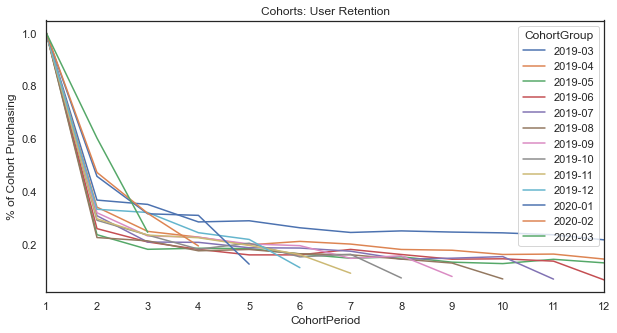

In [40]:
import matplotlib.pyplot as plt
# plot the results
user_retention.plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

In [41]:
import plotly.express as px

fig = px.line(user_retention)
fig.show()

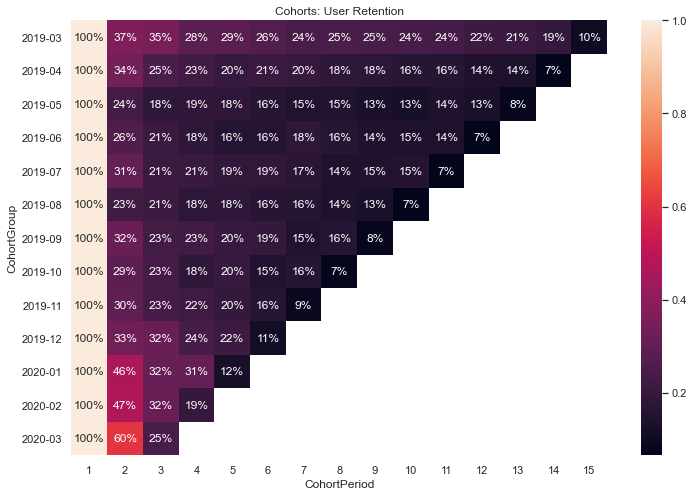

In [42]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

# First Order Characteristics + First Order Cohorts

In [46]:
# add ranking to find other first order characteristics
df['rank'] = df.groupby("customer")["date_purchased_as_date"].rank("dense", ascending=True)
#check on 1 customer
df[df.customer == '25689365012.0']

customer  order_id           source            date_purchased  \
2      25689365012.0  47437194  partner_website  2019-03-13T09:07:31.000Z   
350    25689365012.0  47961540        slicelife  2019-03-20T09:40:13.000Z   
715    25689365012.0  48552231  partner_website  2019-03-28T08:58:29.000Z   
959    25689365012.0  48918864  partner_website  2019-04-01T08:58:35.000Z   
1125   25689365012.0  49160463  partner_website  2019-04-05T08:55:28.000Z   
1325   25689365012.0  49460016  partner_website  2019-04-08T09:32:37.000Z   
1397   25689365012.0  49569750  partner_website  2019-04-10T09:32:41.000Z   
1490   25689365012.0  49702299  partner_website  2019-04-12T09:33:49.000Z   
1783   25689365012.0  50126598        slicelife  2019-04-17T09:26:56.000Z   
2814   25689365012.0  51577092  partner_website  2019-05-06T08:54:52.000Z   
2900   25689365012.0  51687675  partner_website  2019-05-08T09:45:10.000Z   
3360   25689365012.0  52229229  partner_website  2019-05-15T08:37:19.000Z   
3679   25689365012.0  52658835  partner_website  2019-05-20T09:26:49.000Z   
3813   25689365012.0  52831833  partner_website  2019-05-23T08:58:22.000Z   
3879   25689365012.0  52907310  partner_website  2019-05-24T08:39:22.000Z   
4716   25689365012.0  53980689  partner_website  2019-06-07T09:01:40.000Z   
4966   25689365012.0  54330354  partner_website  2019-06-11T08:45:38.000Z   
5005   25689365012.0  54394095  partner_website  2019-06-12T09:19:27.000Z   
5128   25689365012.0  54547266  partner_website  2019-06-14T09:23:58.000Z   
5453   25689365012.0  54949431  partner_website  2019-06-19T08:56:35.000Z   
5507   25689365012.0  55018116  partner_website  2019-06-20T08:47:37.000Z   
5860   25689365012.0  55442142  partner_website  2019-06-25T09:41:49.000Z   
5900   25689365012.0  55506996  partner_website  2019-06-26T09:44:17.000Z   
6019   25689365012.0  55653603  partner_website  2019-06-28T08:43:26.000Z   
6771   25689365012.0  56526957  partner_website  2019-07-09T09:11:20.000Z   
8056   25689365012.0  57875553  partner_website  2019-07-26T08:27:32.000Z   
9458   25689365012.0  59293065  partner_website  2019-08-12T08:55:30.000Z   
10021  25689365012.0  59848866  partner_website  2019-08-19T09:20:00.000Z   
10164  25689365012.0  59967996  partner_website  2019-08-21T09:01:16.000Z   
11825  25689365012.0  61684953        slicelife  2019-09-10T08:45:30.000Z   
12022  25689365012.0  61881819        slicelife  2019-09-13T09:39:27.000Z   
14864  25689365012.0  64654881        slicelife  2019-10-16T09:40:27.000Z   
18306  25689365012.0  67958778  partner_website  2019-11-18T09:05:14.000Z   
18463  25689365012.0  68080659  partner_website  2019-11-20T09:29:29.000Z   
19373  25689365012.0  68830392  partner_website  2019-11-29T09:14:58.000Z   
20586  25689365012.0  69842958  partner_website  2019-12-10T09:14:26.000Z   
22246  25689365012.0  71091588  partner_website  2019-12-23T08:59:04.000Z   
22449  25689365012.0  71236029        slicelife  2019-12-26T08:25:14.000Z   
23999  25689365012.0  72465885  partner_website  2020-01-08T08:30:45.000Z   
24829  25689365012.0  73104060  partner_website  2020-01-15T09:02:51.000Z   
25795  25689365012.0  73848030  partner_website  2020-01-23T08:44:20.000Z   
26680  25689365012.0  74499363        slicelife  2020-01-30T08:56:21.000Z   
27869  25689365012.0  75298185  partner_website  2020-02-07T09:23:27.000Z   
27870  25689365012.0  75298257  partner_website  2020-02-07T09:23:59.000Z   
28980  25689365012.0  75996318  partner_website  2020-02-14T09:11:34.000Z   
29906  25689365012.0  76622571  partner_website  2020-02-20T08:41:51.000Z   
30736  25689365012.0  77161890  partner_website  2020-02-25T08:41:53.000Z   
32005  25689365012.0  77972256  partner_website  2020-03-04T08:36:22.000Z   
33241  25689365012.0  78757116  partner_website  2020-03-12T08:30:11.000Z   

      shipping_type payment_method  promo_value  restaurant_total  shops_id  \
2          Delivery           cash            0             43.24     33699   
350

In [47]:
# separate dimentions for first orders
dims = df[df['rank'] == 1.0][['customer', 'source', 'shipping_type', 'payment_method', 'state']]

In [48]:
# list of orders without dimentions
orders = df[['customer', 'order_id', 'date_purchased_as_date', 'first_order_date', 'promo_value', 'restaurant_total', 'PurchasePeriod', 'CohortGroup']]

In [52]:
df2 = orders.merge(dims, how = 'left', on = 'customer')
df2

customer  order_id    date_purchased_as_date  \
0      13315067198.0  47433960 2019-03-13 08:02:07+00:00   
1      15557129447.0  47434359 2019-03-13 08:11:38+00:00   
2      25689365012.0  47437194 2019-03-13 09:07:31+00:00   
3      25421112251.0  47442942 2019-03-13 11:01:04+00:00   
4      18529185191.0  47443107 2019-03-13 11:04:56+00:00   
...              ...       ...                       ...   
42193  21987304103.0  86341470 2020-05-11 17:56:49+00:00   
42194  25716360551.0  86341677 2020-05-11 17:58:48+00:00   
42195   9610001087.0  86343333 2020-05-11 18:17:20+00:00   
42196  18074100113.0  86346324 2020-05-11 19:07:33+00:00   
42197  13316188268.0  86346558 2020-05-11 19:13:14+00:00   

               first_order_date  promo_value  restaurant_total PurchasePeriod  \
0     2019-03-01 08:02:07+00:00            0             15.50        2019-03   
1     2019-03-01 08:11:38+00:00            0             24.83        2019-03   
2     2019-03-01 09:07:31+00:00            0             43.24        2019-03   
3     2019-03-01 11:01:04+00:00            0             27.95        2019-03   
4     2019-03-01 11:04:56+00:00            0             23.15        2019-03   
...                         ...          ...               ...            ...   
42193 2019-09-01 14:54:39+00:00            0             26.64        2020-05   
42194 2020-03-01 14:42:38+00:00            0             18.59        2020-05   
42195 2019-12-01 17:38:56+00:00            0             44.44        2020-05   
42196 2020-02-01 16:30:13+00:00            0             32.33        2020-05   
42197 2020-01-01 12:16:24+00:00            0             20.65        2020-05   

      CohortGroup           source shipping_type payment_method state  
0         2019-03           iosapp      Delivery         credit    MD  
1         2019-03           iosapp      Delivery         credit    NY  
2         2019-03  partner_website      Delivery           cash    NJ  
3         2019-03  partner_website      Delivery         credit    WI  
4         2019-03  partner_website      Delivery         credit    MA  
...           ...              ...           ...            ...   ...  
42193     2019-09           iosapp      Delivery         credit    NJ  
42194     2020-03  partner_website        Pickup         credit    MA  
42195     2019-12  partner_website      Delivery         credit    MN  
42196     2020-02  partner_website        Pickup         credit    AZ  
42197     2020-01  partner_website      Delivery           cash    MD  

[42198 rows x 12 columns]

In [53]:
# create same retention charts but per each dim variable
def explore_retention(df, by_variable):
    """
    this function helps to transform the data and generate charts for each category in the variable of interest
    """

    # find all unique values in the variable to loop thru
    list_unique = df[by_variable].unique()

    for each in list_unique:
        print(each)
        df2 = df[df[by_variable] == each]
        grouped = df2.groupby(['CohortGroup', 'PurchasePeriod'])

        # count the unique users, orders, and total revenue per Group + Period
        cohorts = grouped.agg({'customer': pd.Series.nunique,
                               'order_id': pd.Series.nunique,
                               'restaurant_total': np.sum})

        # make the column names more meaningful
        cohorts.rename(columns={'customer': 'TotalUsers',
                                'order_id': 'TotalOrders',
                                'restaurant_total': 'TotalRevenue'}, inplace=True)

        # adding cohort period
        cohorts = cohorts.groupby(level=0).apply(set_cohort_period)

        # reindex the DataFrame
        cohorts.reset_index(inplace=True)
        cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
        # create a Series holding the total size of each CohortGroup
        cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
        print(cohort_group_size)

        # show absolute number of users per Cohort Group and Cohort Period
        cohorts['TotalUsers'].unstack(0).head()

        # find pct of users who make purchase in a given time frame
        user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

        # plot the results
        user_retention.plot(figsize=(10,5))
        plt.title('Cohorts: User Retention by ' + by_variable + ' = ' + each)
        plt.xticks(np.arange(1, 12.1, 1))
        plt.xlim(1, 12)
        plt.ylabel('% of Cohort Purchasing');
#        fig = px.line(user_retention, title = 'Retention by ' + var + ' = ' + each )
#        fig.show()

## Retention by source

iosapp
CohortGroup
2019-03    242
2019-04    230
2019-05    240
2019-06    222
2019-07    264
2019-08    256
2019-09    224
2019-10    232
2019-11    286
2019-12    281
2020-01    168
2020-02    157
2020-03    186
Name: TotalUsers, dtype: int64
partner_website
CohortGroup
2019-03    313
2019-04    353
2019-05    431
2019-06    418
2019-07    488
2019-08    468
2019-09    355
2019-10    397
2019-11    501
2019-12    434
2020-01    577
2020-02    722
2020-03    660
Name: TotalUsers, dtype: int64
slicelife
CohortGroup
2019-03     80
2019-04     86
2019-05     72
2019-06     40
2019-07     73
2019-08     67
2019-09     62
2019-10     80
2019-11    117
2019-12    103
2020-01    127
2020-02    165
2020-03    191
Name: TotalUsers, dtype: int64
androidapp
CohortGroup
2019-03    40
2019-04    18
2019-05    12
2019-06     6
2019-07    17
2019-08    12
2019-09    10
2019-10     9
2019-11    13
2019-12     9
2020-01     5
2020-02     2
2020-03     2
Name: TotalUsers, dtype: int64
partner_button
Co

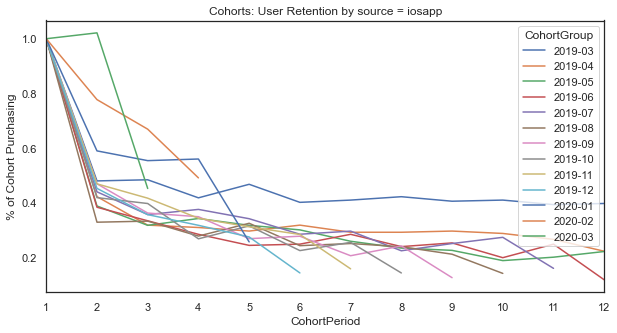

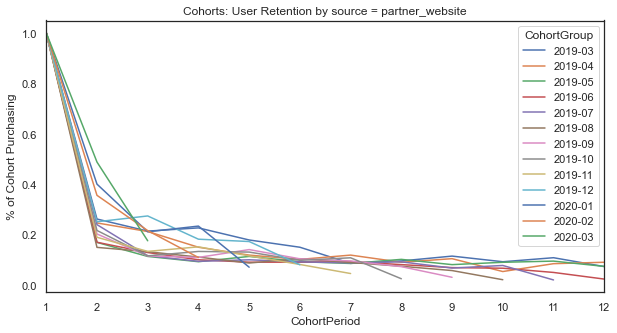

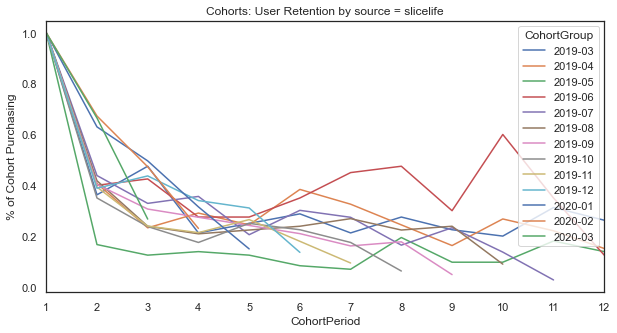

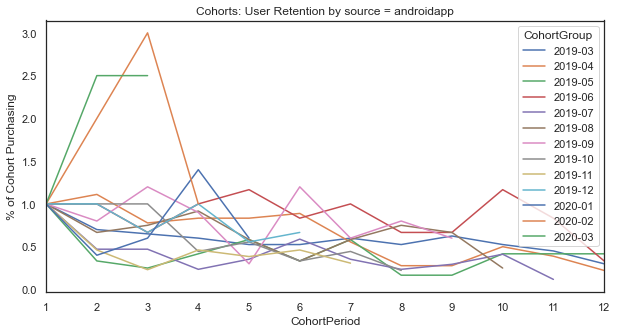

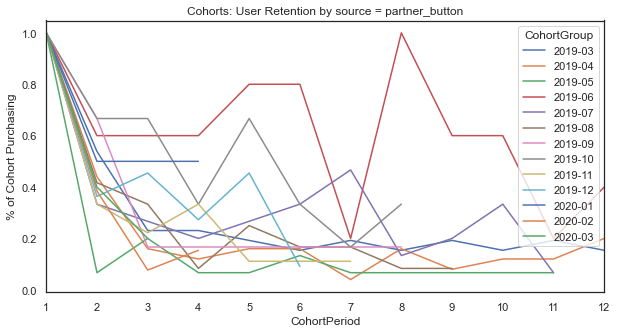

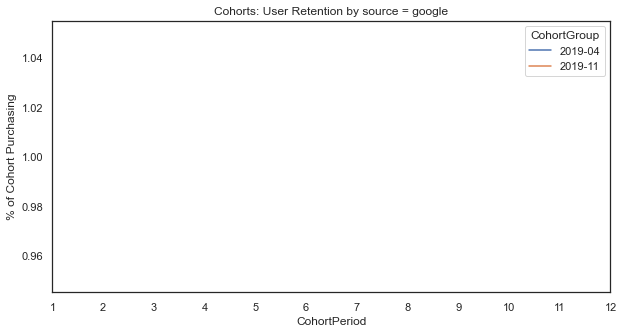

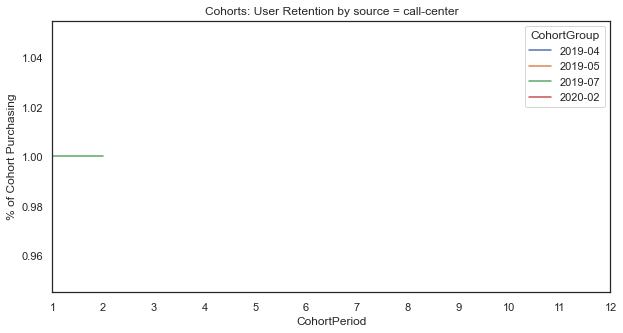

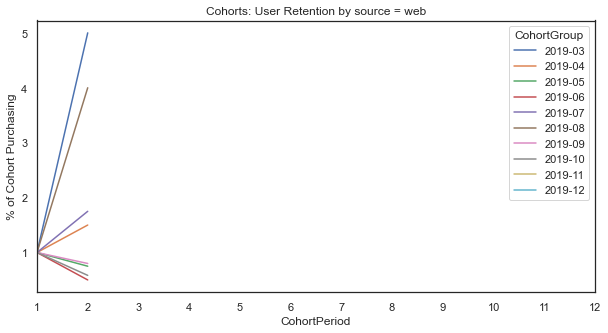

In [26]:
explore_retention(df, 'source')

## Retention by shipping_type

Delivery
CohortGroup
2019-03    469
2019-04    455
2019-05    456
2019-06    423
2019-07    520
2019-08    489
2019-09    375
2019-10    418
2019-11    536
2019-12    539
2020-01    488
2020-02    574
2020-03    528
Name: TotalUsers, dtype: int64
Pickup
CohortGroup
2019-03    218
2019-04    242
2019-05    298
2019-06    263
2019-07    321
2019-08    320
2019-09    260
2019-10    305
2019-11    378
2019-12    301
2020-01    373
2020-02    439
2020-03    504
Name: TotalUsers, dtype: int64


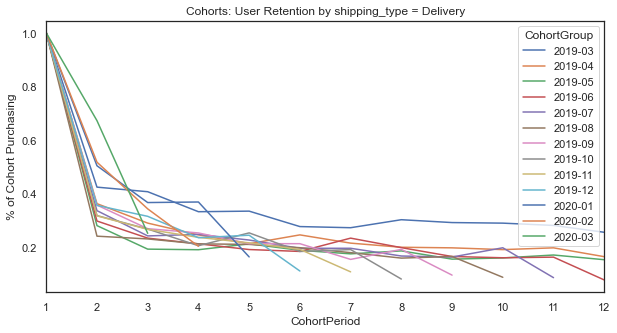

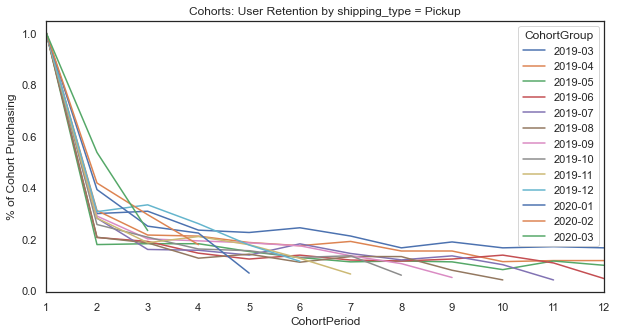

In [27]:
explore_retention(df, 'shipping_type')

## Retention by payment_method

credit
CohortGroup
2019-03    546
2019-04    553
2019-05    561
2019-06    497
2019-07    632
2019-08    626
2019-09    480
2019-10    551
2019-11    699
2019-12    656
2020-01    636
2020-02    747
2020-03    897
Name: TotalUsers, dtype: int64
cash
CohortGroup
2019-03    132
2019-04    134
2019-05    179
2019-06    178
2019-07    202
2019-08    172
2019-09    146
2019-10    164
2019-11    195
2019-12    168
2020-01    204
2020-02    249
2020-03    113
Name: TotalUsers, dtype: int64


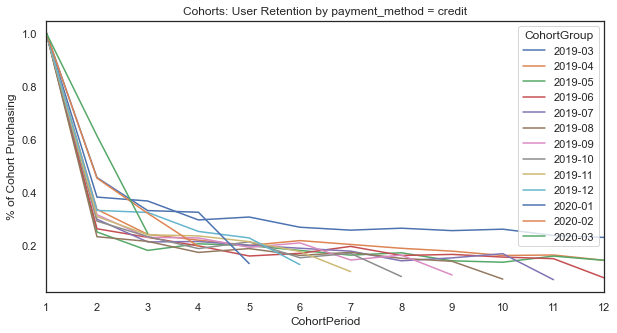

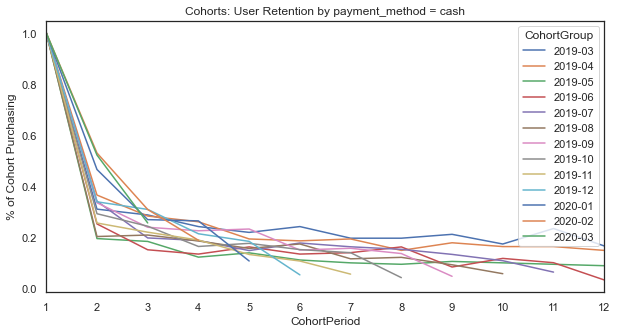

In [54]:
explore_retention(df2, 'payment_method')

## Retention by state

In [ ]:
explore_retention(df2, 'state')

## Retention by promo values

In [67]:
# convert to date
# df2['date_purchased_as_date'] = df2['date_purchased_as_date'].dt.date
df2['first_order_date'] = df2['first_order_date'].dt.date

In [68]:
# if customer ordered again after 90 days since first order consider them retained

# find difference
df2['days_from_first_order'] = (df2['date_purchased_as_date']-df2['first_order_date']).dt.days

# find max diff in days between first and last order
df2.set_index('customer', inplace=True)
df2['days_from_first_order_max'] = df2.groupby(level=0)['days_from_first_order'].max().apply(lambda x: x)
df2.reset_index(inplace=True)

# if order days ago > 90 consider a customer retained
#df2['is_retained'][df2.order_days_ago_max >= 90] = True
#df2['is_retained'][df2.order_days_ago_max < 90] = False
df2.loc[df2.days_from_first_order_max >= 90, 'is_retained'] = True
df2.loc[df2.days_from_first_order_max < 90, 'is_retained'] = False

In [69]:
df2

customer  order_id date_purchased_as_date first_order_date  \
0      13315067198.0  47433960             2019-03-13       2019-03-01   
1      15557129447.0  47434359             2019-03-13       2019-03-01   
2      25689365012.0  47437194             2019-03-13       2019-03-01   
3      25421112251.0  47442942             2019-03-13       2019-03-01   
4      18529185191.0  47443107             2019-03-13       2019-03-01   
...              ...       ...                    ...              ...   
42193  21987304103.0  86341470             2020-05-11       2019-09-01   
42194  25716360551.0  86341677             2020-05-11       2020-03-01   
42195   9610001087.0  86343333             2020-05-11       2019-12-01   
42196  18074100113.0  86346324             2020-05-11       2020-02-01   
42197  13316188268.0  86346558             2020-05-11       2020-01-01   

       promo_value  restaurant_total PurchasePeriod CohortGroup  \
0                0             15.50        2019-03     2019-03   
1                0             24.83        2019-03     2019-03   
2                0             43.24        2019-03     2019-03   
3                0             27.95        2019-03     2019-03   
4                0             23.15        2019-03     2019-03   
...            ...               ...            ...         ...   
42193            0             26.64        2020-05     2019-09   
42194            0             18.59        2020-05     2020-03   
42195            0             44.44        2020-05     2019-12   
42196            0             32.33        2020-05     2020-02   
42197            0             20.65        2020-05     2020-01   

                source shipping_type payment_method state  \
0               iosapp      Delivery         credit    MD   
1               iosapp      Delivery         credit    NY   
2      partner_website      Delivery           cash    NJ   
3      partner_website      Delivery         credit    WI   
4      partner_website      Delivery         credit    MA   
...                ...           ...            ...   ...   
42193           iosapp      Delivery         credit    NJ   
42194  partner_website        Pickup         credit    MA   
42195  partner_website      Delivery         credit    MN   
42196  partner_website        Pickup         credit    AZ   
42197  partner_website      Delivery           cash    MD   

       days_from_first_order  days_from_first_order_max is_retained  
0                       12.0                      113.0        True  
1                       12.0                      394.0        True  
2                       12.0                      377.0        True  
3                       12.0                      264.0        True  
4                       12.0                       12.0       False  
...                      ...                        ...         ...  
42193                  253.0                      253.0        True  
42194                   71.0                       71.0       False  
42195                  162.0                      162.0        True  
42196                  100.0                      100.0        True  
42197                  131.0                      131.0        True  

[42198 rows x 15 columns]

In [ ]:
df2[df2.customer == '15557129447.0']

In [ ]:
# count retained customers per promo value
retained = df2[df2['is_retained'] == True].groupby(['promo_value'])['customer'].nunique()
print(retained)

In [ ]:
# count total customers per promo value
total_customers = df2.groupby(['promo_value'])['customer'].nunique()
print(total_customers)

In [ ]:
# retention rate per promo value
promo_retention_rate = (retained/total_customers)*100
print(promo_retention_rate)

In [ ]:
import matplotlib.pyplot as plt
# Create a bar chart 
promo_retention_rate.plot(kind = 'bar')
# Add a title and x and y-axis labels
plt.title('3 monts retention rate by promo\n', size = 16)
plt.xlabel('Promo value', size = 14)
plt.ylabel('Retention rate (%)', size = 14)
# Display the plot
plt.show()

## Retention by promo value over time

In [ ]:
# calculate retention rate over time
# count retained customers per promo value
retained = df2[df2['is_retained'] == True].groupby(['promo_value', 'first_order_date'])['customer'].nunique()
#print(retained)

# count total customers per promo value
total_customers = df2.groupby(['promo_value', 'first_order_date'])['customer'].nunique()
#print(total_customers)

# retention rate per promo value
promo_retention_rate = (retained/total_customers)*100
promo_retention_rate = promo_retention_rate.unstack(level=0)
print(promo_retention_rate)

In [ ]:
# plot retention over time
#promo_retention_rate.plot(x=first_order_date, y=['0','1','2','3','4','5'])
#plt.show()

promo_retention_rate.plot(figsize=(10,5))
plt.title('Daily 3 months retention rate\n', size = 16)
plt.ylabel('Retention rate (%)', size = 14)
plt.show()

## One factor ANOVA

In [ ]:
from scipy import stats
zero = df2[df2.promo_value == "0"].Production


anova = stats.f
_
oneway(array_
fertA, array_
fertB, array_
fertC)
print(anova[1])